# Fashion MNIST benchmarks

## Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from ff import FF, FFLayer
from data import MergedDataset, FashionMNIST
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset

The batch sizes

In [3]:
batch_size_train = 512
batch_size_test = 512

Creating 3 different types of loaders, one for train positive, one for train negative with masks and another for test.

In [4]:
# load fashion-mnist FASHIOn-MNIST
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./datasets/FashionMNIST', train=True, download=True,
                          transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(
                                (0.2860,), (0.3530,))
                            ])),
    batch_size=batch_size_train, shuffle=True)

train_loader_negative = torch.utils.data.DataLoader(MergedDataset(torchvision.datasets.FashionMNIST('./datasets/FashionMNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), 5, FashionMNIST.negative_data_generation), batch_size=batch_size_train, shuffle=True)    

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('./datasets/FashionMNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Showing 4 random images from the FMNIST dataset.

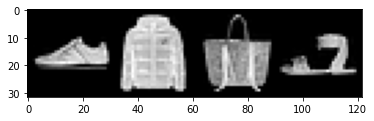

    7     4     8     5


In [5]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:4], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# print labels
print(' '.join('%5s' % labels[j].item() for j in range(4)))


Showing a negative data point made with masks

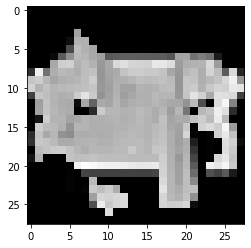

In [6]:
image = next(iter(train_loader_negative))
image = image.reshape((-1, 1, 28, 28))[0]
plt.imshow(image.reshape((28, 28)), cmap='gray')

## Parameters and model

We set the threshold, training parameters, learning rates, goodness function and time spent awake and sleeping.

In [7]:
threshold = 1.5
epochs_per_layer = 50

optim_config = {
    "lr": 0.001,
}
positive_optim_config = {
    "lr": 0.001,

}
negative_optim_config = {
    "lr": 0.001,
}

goodness_function = lambda x: x.pow(2).mean(1)
awake_period = 1
sleep_period = 1

Model declaration

In [8]:

model = FF(device=device)

# First layer
model.add_layer(FFLayer(nn.Linear(784, 500).to(device), 
                        optimizer=torch.optim.Adam, 
                        epochs=epochs_per_layer, 
                        threshold=threshold, 
                        activation=nn.ReLU(), 
                        optim_config=optim_config, 
                        positive_optim_config=positive_optim_config, 
                        negative_optim_config=negative_optim_config, 
                        name="layer 1", 
                        device = device, 
                        goodness_function=goodness_function).to(device))
# Second layer
model.add_layer(FFLayer(nn.Linear(500, 500).to(device), 
                        optimizer=torch.optim.Adam, 
                        epochs=epochs_per_layer, 
                        threshold=threshold, 
                        activation=nn.ReLU(), 
                        optim_config=optim_config, 
                        positive_optim_config=positive_optim_config, 
                        negative_optim_config=negative_optim_config, 
                        name="layer 2", 
                        device = device, 
                        goodness_function=goodness_function).to(device))
# Last layer
model.add_layer(FFLayer(nn.Linear(500, 500).to(device), 
                        optimizer=torch.optim.Adam, 
                        epochs=epochs_per_layer, 
                        threshold=threshold, 
                        activation=nn.ReLU(), 
                        optim_config=optim_config, 
                        positive_optim_config=positive_optim_config, 
                        negative_optim_config=negative_optim_config, 
                        name="layer 3", 
                        device = device, 
                        goodness_function=goodness_function).to(device))

model = model.to(device)

## Train

In [11]:
epochs = 500
hour = 0
print_every = 10
with_masks = False

def get_random_number_besides(x):
    num = random.randint(0,9)
    if num==x: return get_random_number_besides(x)
    return num

def get_negative_y(y):
    return torch.tensor([get_random_number_besides(i) for i in y], dtype = torch.long).to(device)

for i in tqdm(range(epochs), desc="Epochs"):
    if i % print_every == 1:
        predictions, real = FashionMNIST.predict(test_loader, model, device)
        acc = np.sum(predictions == real)/len(real)
        print("Accuracy on test data: ", acc)
        
        predictions, real = FashionMNIST.predict(train_loader, model, device)
        acc = np.sum(predictions == real)/len(real)
        print("Accuracy on train data: ", acc)
        

    model.train()

    if with_masks:
        
        for a, b in tqdm(zip(enumerate(train_loader), enumerate(train_loader_negative)), desc="Training currently at hour: " + str(hour) + f" which is in {'Awake' if hour % (awake_period + sleep_period) < awake_period else 'Sleep' } state", total=len(train_loader)):

            x_pos = a[1][0].to(device)
            y = a[1][1].to(device)


            if hour % (awake_period + sleep_period) < awake_period:
                x_pos,_ = FashionMNIST.overlay_y_on_x(x_pos, y)
                model.forward_positive(x_pos)
            else:
                x_neg,_ = FashionMNIST.overlay_y_on_x(b[1].to(device), y)
                model.forward_negative(x_neg)

            hour += 1
            print("Training currently at hour: " + str(hour) + f" which is in {'Awake' if hour % (awake_period + sleep_period) < awake_period else 'Sleep' } state")
    else:

        for a in tqdm(enumerate(train_loader), desc="Training", total=len(train_loader)):
            x_pos = a[1][0].to(device)
            y = a[1][1].to(device)
            if hour % (awake_period + sleep_period) < awake_period:
                x_pos,_ = FashionMNIST.overlay_y_on_x(x_pos, y)
                model.forward_positive(x_pos)
            else:
                x_neg,_ = FashionMNIST.overlay_y_on_x(x_pos, get_negative_y(y))
                model.forward_negative(x_neg)
            hour += 1
            print("Training currently at hour: " + str(hour) + f" which is in {'Awake' if hour % (awake_period + sleep_period) < awake_period else 'Sleep' } state")

Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training currently at hour: 1 which is in Sleep state


Training currently at hour: 2 which is in Awake state


Training currently at hour: 3 which is in Sleep state


Training currently at hour: 4 which is in Awake state


Training currently at hour: 5 which is in Sleep state


Training currently at hour: 6 which is in Awake state


Training currently at hour: 7 which is in Sleep state


Training currently at hour: 8 which is in Awake state


Epochs:   0%|          | 0/500 [00:23<?, ?it/s]


KeyboardInterrupt: 